# prep

In [215]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [216]:
def load_data(dir_path):
    file_path = dir_path.replace('\\', '/')
    data = sio.loadmat(file_path + '/trace_trial_stim.mat')
    
    stim_seq = data['stim_seq']
    stim_id = [i[0] for i in stim_seq]
    trace_by_trial = data['trace_by_trial']

    ncell = trace_by_trial.shape[0]
    nstim = len(np.unique(stim_id))
    ntrial = trace_by_trial.shape[1]
    nframe = trace_by_trial.shape[2]
    print(ncell, nstim, ntrial, nframe)

    return stim_id, trace_by_trial, # ncell, nstim, ntrial, nframe


def calc_trace_stim(trace_by_trial, stim_id):
    trace_avg_cell = np.mean(np.mean(trace_by_trial, axis=0), axis=0)
    trace_stim_avg = []
    # trace_stim_std = []
    # trace_stim_sem = []

    for i in np.unique(stim_id):
        trace_istim_avg = np.mean(trace_by_trial[:, np.where(stim_id == i)[0]], axis=1) # ncell x nframe
        trace_istim_avg = np.mean(trace_istim_avg, axis=0) # nframe
        # trace_istim_std = np.std(trace_by_trial[:, np.where(stim_id == i)[0]], axis=1)
        # trace_istim_sem = trace_istim_std / np.sqrt(len(np.where(stim_id == i)[0]))

        trace_stim_avg.append(trace_istim_avg)
        # trace_stim_std.append(trace_istim_std)
        # trace_stim_sem.append(trace_istim_sem)

    print(len(trace_stim_avg), trace_stim_avg[0].shape)
    return trace_avg_cell, trace_stim_avg

# compare trace

In [217]:
# i1369 V1 high res, cellpose
dir_path = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1369_220310_cellpose'
stim_id_cellpose, trace_by_trial_cellpose = load_data(dir_path)
trace_avg_cell_cellpose, trace_stim_avg_cellpose = calc_trace_stim(trace_by_trial_cellpose, stim_id_cellpose)

# i1369 V1 high res, manual
dir_path = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1369_220310'
stim_id_manual, trace_by_trial_manual = load_data(dir_path)
trace_avg_cell_manual, trace_stim_avg_manual = calc_trace_stim(trace_by_trial_manual, stim_id_manual)

114 30 511 156
30 (156,)
155 30 511 156
30 (156,)


In [218]:
# normalize trace to same max min
trace_avg_cell_cellpose_norm = (trace_avg_cell_cellpose - np.min(trace_avg_cell_cellpose)) / (np.max(trace_avg_cell_cellpose) - np.min(trace_avg_cell_cellpose))
trace_avg_cell_manual_norm = (trace_avg_cell_manual - np.min(trace_avg_cell_manual)) / (np.max(trace_avg_cell_manual) - np.min(trace_avg_cell_manual))

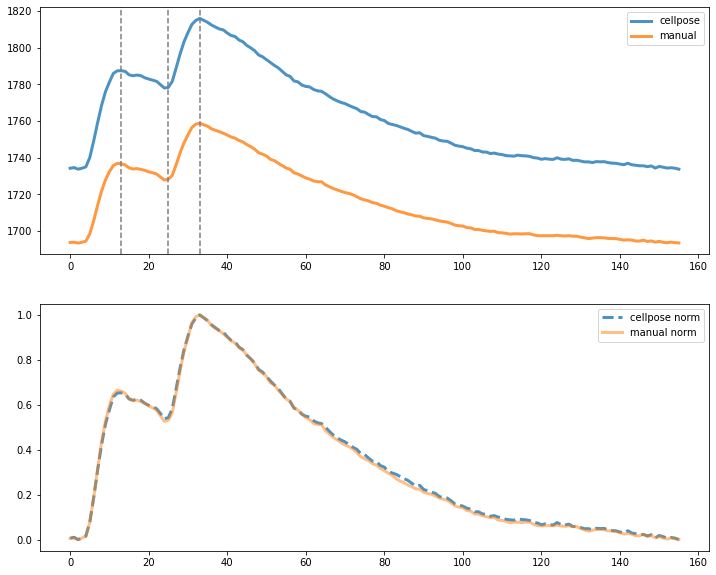

In [219]:
# try no normalization
plt.figure(figsize=(12, 10))

plt.subplot(2,1,1)
plt.plot(trace_avg_cell_cellpose, alpha=0.8, linewidth=3) # - 50
plt.plot(trace_avg_cell_manual, alpha=0.8, linewidth=3)

plt.axvline(x=np.argmax(trace_avg_cell_cellpose[:25]), color='gray', linestyle='--')
plt.axvline(x=np.argmin(trace_avg_cell_cellpose[25:30]) + 25, color='gray', linestyle='--')
plt.axvline(x=np.argmax(trace_avg_cell_cellpose), color='gray', linestyle='--')
plt.legend(['cellpose', 'manual'])

plt.subplot(2,1,2)
plt.plot(trace_avg_cell_cellpose_norm, alpha=0.8, linewidth=3, linestyle='--')
plt.plot(trace_avg_cell_manual_norm, alpha=0.5, linewidth=3)
plt.legend(['cellpose norm', 'manual norm'])

# compare resp

In [220]:
d = {'mouse': [1369, 1369], 'date': ['220310', '220310_cellpose'], 'area': ['V1', 'V1']}
meta = pd.DataFrame(data=d)
print(meta)

   mouse             date area
0   1369           220310   V1
1   1369  220310_cellpose   V1


In [284]:
nset = len(meta.index); ncell = []; nori = 30; nframe_trial = 156
dir_name = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter'.replace('\\', '/')

def load_dfof(iset):
    dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])
    dfof = sio.loadmat(os.path.join(dir_name, dir_sub, 'dfof' + '.mat'))
    dfof_ad = dfof['dfof_ad']
    dfof_tg = dfof['dfof_tg']
    ncell = dfof['dfof_ad'].shape[0]
    return dfof_ad, dfof_tg, ncell

def threshold_dfof(dfof_ad, dfof_tg, thres_perc_low=1, thres_perc_high=95):
    thres_low = np.percentile(dfof_ad.flatten(), thres_perc_low)
    thres_high = np.percentile(dfof_ad.flatten(), thres_perc_high)
    dfof_ad_thres = dfof_ad.copy()
    dfof_ad_thres[dfof_ad_thres < thres_low] = np.nan # turn off left thres bc right tail is heavy
    dfof_ad_thres[dfof_ad_thres > thres_high] = np.nan
    dfof_tg_thres = dfof_tg.copy()
    dfof_tg_thres[dfof_tg_thres < thres_low] = np.nan # threshold resp_tg by resp_tg
    dfof_tg_thres[dfof_tg_thres > thres_high] = np.nan
    return dfof_ad_thres, dfof_tg_thres

def calc_adp(dfof_ad, dfof_tg, thres=np.nan):
    adp = (dfof_tg - dfof_ad) / (dfof_tg + dfof_ad + 1e-7) # changed definition of adp to (tg - ad) / (tg + ad)
    if thres is not np.nan:
        adp[adp > thres] = np.nan
        adp[adp < -thres] = np.nan
    return adp

## extreme resp pair co-occur?

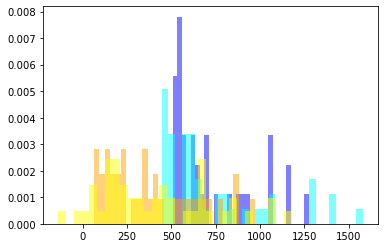

In [222]:
# check if extreme value of dfof_ad and dfof_tg co-occur -> not really
# conclusion: should threshold both dfof_ad and dfof_tg at top / bottom 5% (substitute with np.nan)

dfof_ad_cellpose, dfof_tg_cellpose, ncell_cellpose = load_dfof(1)
dfof_ad_manual, dfof_tg_manual, ncell_manual = load_dfof(0)
large_ad_cellpose_id = dfof_ad_cellpose.flatten() > np.percentile(dfof_ad_cellpose.flatten(), 99)
large_ad_manual_id = dfof_ad_manual.flatten() > np.percentile(dfof_ad_manual.flatten(), 99)

large_ad_cellpose = dfof_ad_cellpose.flatten()[large_ad_cellpose_id]
large_ad_manual = dfof_ad_manual.flatten()[large_ad_manual_id]
large_ad_tg_cellpose = dfof_tg_cellpose.flatten()[large_ad_cellpose_id] # tg corresponding to large_ad
large_ad_tg_manual = dfof_tg_manual.flatten()[large_ad_manual_id]

plt.hist(large_ad_cellpose.flatten(), bins=30, alpha=0.5, density=True, color='b');
plt.hist(large_ad_manual.flatten(), bins=30, alpha=0.5, density=True, color='cyan');
plt.hist(large_ad_tg_cellpose.flatten(), bins=30, alpha=0.5, density=True, color='orange');
plt.hist(large_ad_tg_manual.flatten(), bins=30, alpha=0.5, density=True, color='yellow');

## resp dist

In [281]:
def plot_dfof(dfof_ad_cellpose, dfof_tg_cellpose, dfof_ad_manual, dfof_tg_manual):
    dfof_ad_cellpose_median = np.nanmedian(dfof_ad_cellpose.flatten())
    dfof_ad_manual_median = np.nanmedian(dfof_ad_manual.flatten())
    dfof_tg_cellpose_median = np.nanmedian(dfof_tg_cellpose.flatten())
    dfof_tg_manual_median = np.nanmedian(dfof_tg_manual.flatten())

    # xlow = -100
    # xhigh = 200

    plt.figure(figsize=(12, 10))
    plt.subplot(2,2,1)
    plt.hist(dfof_ad_cellpose.flatten(), bins=100, alpha=0.5, density=True, color='b');
    plt.axvline(x=dfof_ad_cellpose_median, color='b', linestyle='--')
    plt.hist(dfof_ad_manual.flatten(), bins=100, alpha=0.5, density=True, color='cyan');
    plt.axvline(x=dfof_ad_manual_median, color='cyan', linestyle='--')
    # plt.xlim([xlow, xhigh])
    plt.legend(['cellpose ad', 'manual ad'])

    plt.subplot(2,2,2)
    plt.hist(dfof_tg_cellpose.flatten(), bins=100, alpha=0.5, density=True, color='orange');
    plt.axvline(x=dfof_tg_cellpose_median, color='orange', linestyle='--')
    plt.hist(dfof_tg_manual.flatten(), bins=100, alpha=0.5, density=True, color='yellow');
    plt.axvline(x=dfof_tg_manual_median, color='yellow', linestyle='--')
    # plt.xlim([xlow, xhigh])
    plt.legend(['cellpose tg', 'manual tg'])

    plt.subplot(2,2,3)
    plt.hist(dfof_ad_cellpose.flatten(), bins=100, alpha=0.5, density=True, color='b');
    plt.axvline(x=dfof_ad_cellpose_median, color='b', linestyle='--')
    plt.hist(dfof_tg_cellpose.flatten(), bins=100, alpha=0.5, density=True, color='orange');
    plt.axvline(x=dfof_tg_cellpose_median, color='orange', linestyle='--')
    # plt.xlim([xlow, xhigh])
    plt.legend(['cellpose ad', 'cellpose tg'])

    plt.subplot(2,2,4)
    plt.hist(dfof_ad_manual.flatten(), bins=100, alpha=0.5, density=True, color='cyan');
    plt.axvline(x=dfof_ad_manual_median, color='cyan', linestyle='--')
    plt.hist(dfof_tg_manual.flatten(), bins=100, alpha=0.5, density=True, color='yellow');
    plt.axvline(x=dfof_tg_manual_median, color='yellow', linestyle='--')
    # plt.xlim([xlow, xhigh])
    plt.legend(['manual ad', 'manual tg']);

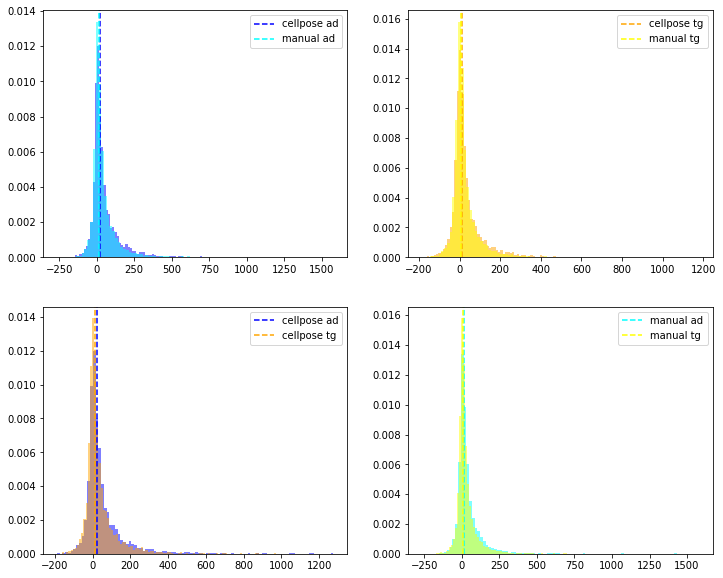

In [282]:
# check distribution of response to adapter and target, original value w/o thresholding

dfof_ad_cellpose, dfof_tg_cellpose, ncell_cellpose = load_dfof(1)
dfof_ad_manual, dfof_tg_manual, ncell_manual = load_dfof(0)
plot_dfof(dfof_ad_cellpose, dfof_tg_cellpose, dfof_ad_manual, dfof_tg_manual)


## find resp thres

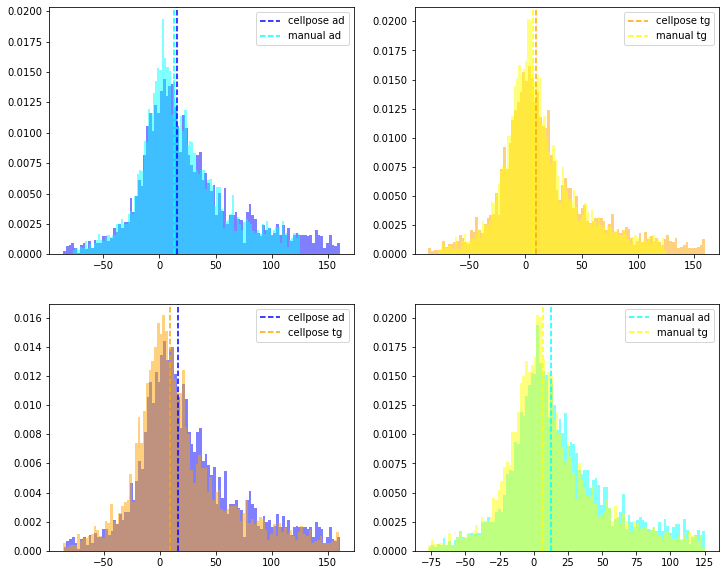

In [287]:
thres_perc_low = 1
thres_perc_high = 90

dfof_ad_manual, dfof_tg_manual, ncell_manual = load_dfof(0)
dfof_ad_manual, dfof_tg_manual = threshold_dfof(dfof_ad_manual, dfof_tg_manual, 
                                                thres_perc_low=thres_perc_low, thres_perc_high=thres_perc_high)

dfof_ad_cellpose, dfof_tg_cellpose, ncell_cellpose = load_dfof(1)
dfof_ad_cellpose, dfof_tg_cellpose = threshold_dfof(dfof_ad_cellpose, dfof_tg_cellpose, 
                                                    thres_perc_low=thres_perc_low, thres_perc_high=thres_perc_high)

plot_dfof(dfof_ad_cellpose, dfof_tg_cellpose, dfof_ad_manual, dfof_tg_manual)


# compare adp

In [290]:
dfof_ad_cellpose, dfof_tg_cellpose, ncell_cellpose = load_dfof(1)
dfof_ad_cellpose, dfof_tg_cellpose = threshold_dfof(dfof_ad_cellpose, dfof_tg_cellpose, thres_perc_low=thres_perc_low, thres_perc_high=thres_perc_high)
adp_cellpose = calc_adp(dfof_ad_cellpose, dfof_tg_cellpose, thres=5) # threshold adp to rid of extreme values

dfof_ad_manual, dfof_tg_manual, ncell_manual = load_dfof(0)
dfof_ad_manual, dfof_tg_manual = threshold_dfof(dfof_ad_manual, dfof_tg_manual, thres_perc_low=thres_perc_low, thres_perc_high=thres_perc_high)
adp_manual = calc_adp(dfof_ad_manual, dfof_tg_manual, thres=5)

print(adp_cellpose.shape, adp_manual.shape)
np.nanmedian(adp_manual.flatten()), np.nanmedian(adp_cellpose.flatten()), np.nanmean(adp_manual.flatten()), np.nanmean(adp_cellpose.flatten())

(114, 30) (155, 30)


(-0.1179842047075219,
 -0.13520961730384784,
 -0.14129317064516084,
 -0.1513433833295991)

cellpose adp median: -0.14, cellpose mean: -0.15
manual adp median: -0.12, manual mean: -0.14


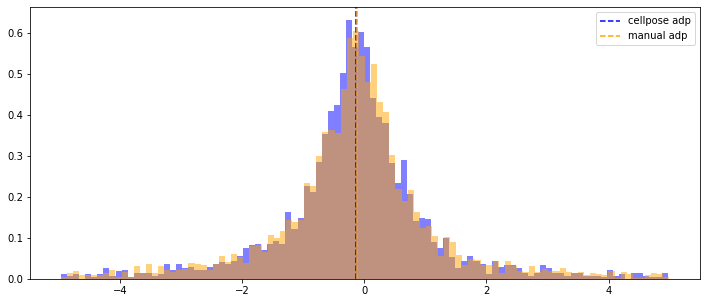

In [291]:
plt.figure(figsize=(12, 5))
plt.hist(adp_cellpose.flatten(), bins=100, alpha=0.5, density=True, color='b');
plt.axvline(x=np.nanmedian(adp_cellpose.flatten()), color='b', linestyle='--')
print(f'cellpose adp median: {np.nanmedian(adp_cellpose.flatten()):.2f}, cellpose mean: {np.nanmean(adp_cellpose.flatten()):.2f}')

plt.hist(adp_manual.flatten(), bins=100, alpha=0.5, density=True, color='orange');
plt.axvline(x=np.nanmedian(adp_manual.flatten()), color='orange', linestyle='--')
print(f'manual adp median: {np.nanmedian(adp_manual.flatten()):.2f}, manual mean: {np.nanmean(adp_manual.flatten()):.2f}')

plt.legend(['cellpose adp', 'manual adp']);
# plt.yscale('log') # use if density=False
# plt.xlim([-200, 200]); # use if adp not thresholded

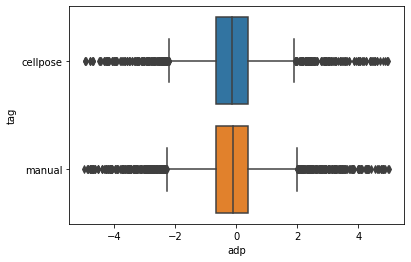

In [292]:
df1 = pd.DataFrame(data=adp_cellpose.flatten(), columns=['adp'])
df1['tag'] = 'cellpose'
df2 = pd.DataFrame(data=adp_manual.flatten(), columns=['adp'])
df2['tag'] = 'manual'

df = pd.concat([df1, df2], axis=0)
ax = sns.boxplot(x="adp", y="tag", data=df) # , whis=np.inf

## adp thres is necessary
thresholding resp_ad and tg does not help
### 3d scatter: resp ad, resp tg, adp

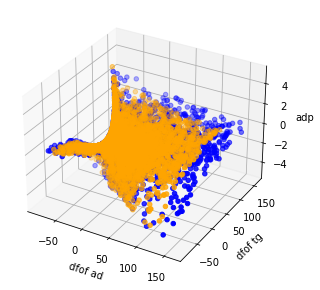

In [294]:
# 3d scatterplot
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfof_ad_cellpose.flatten(), dfof_tg_cellpose.flatten(), adp_cellpose.flatten(), c='b', marker='o')
ax.scatter(dfof_ad_manual.flatten(), dfof_tg_manual.flatten(), adp_manual.flatten(), c='orange', marker='o')
ax.set_xlabel('dfof ad')
ax.set_ylabel('dfof tg')
ax.set_zlabel('adp');

In [ ]:
# go scatterplot 3d
import plotly.graph_objs as go
go.scatter3d(x=dfof_ad_cellpose.flatten(), y=dfof_tg_cellpose.flatten(), z=adp_cellpose.flatten(), mode='markers', marker=dict(size=2, color='b'))

## compare adp by stim

In [269]:
dfof_ad_cellpose, dfof_tg_cellpose, ncell_cellpose = load_dfof(1)
dfof_ad_cellpose, dfof_tg_cellpose = threshold_dfof(dfof_ad_cellpose, dfof_tg_cellpose) # cellpose did not filter by vis-driven
adp_cellpose = calc_adp(dfof_ad_cellpose, dfof_tg_cellpose, thres=5) # no threshold, see if groupby stim works

dfof_ad_manual, dfof_tg_manual, ncell_manual = load_dfof(0)
dfof_ad_manual, dfof_tg_manual = threshold_dfof(dfof_ad_manual, dfof_tg_manual)
adp_manual = calc_adp(dfof_ad_manual, dfof_tg_manual, thres=5)

print(adp_cellpose.shape, adp_manual.shape)
np.nanmedian(adp_manual.flatten()), np.nanmedian(adp_cellpose.flatten()), np.nanmean(adp_manual.flatten()), np.nanmean(adp_cellpose.flatten())

(114, 30) (155, 30)


(-0.13138378886110952,
 -0.1517251272241036,
 -0.15110796846209582,
 -0.15983578619862884)

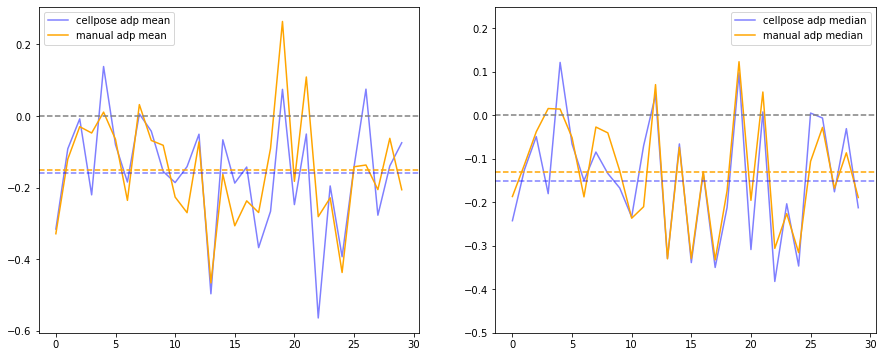

In [270]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.plot(np.nanmean(adp_cellpose, axis=0), color='b', alpha=0.5)
plt.plot(np.nanmean(adp_manual, axis=0), color='orange')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=np.nanmean(adp_cellpose.flatten()), color='b', linestyle='--', alpha=0.5)
plt.axhline(y=np.nanmean(adp_manual.flatten()), color='orange', linestyle='--')
plt.legend(['cellpose adp mean', 'manual adp mean'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(np.nanmedian(adp_cellpose, axis=0), color='b', alpha=0.5)
plt.plot(np.nanmedian(adp_manual, axis=0), color='orange')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=np.nanmedian(adp_cellpose.flatten()), color='b', linestyle='--', alpha=0.5)
plt.axhline(y=np.nanmedian(adp_manual.flatten()), color='orange', linestyle='--')
plt.ylim([-0.5,0.25])
plt.legend(['cellpose adp median', 'manual adp median'], loc='upper right');